In [0]:
from google.colab import drive
drive.mount("/content/gdrive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
from pandas import read_csv
import itertools as itr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import math
import matplotlib.pyplot as plt

refine = 0
look_back = 4
n_seq = 4
batch_size = 8
epochs = 200
timesteps = 4


# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, n_seq=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-n_seq):
		a = dataset[i:(i+look_back), :]# 0 is removed
		dataX.append(a)
		dataY.append(dataset[(i + look_back):(i + look_back + n_seq), 0])
	return np.array(dataX), np.array(dataY)


def permute_list(param_list, max_permute):    
    output_list = list()
    for i in range(max_permute + 1):
        a = itr.combinations(param_list, i)
        output_list = output_list + [x for x in a]
    return [['inf'] + list(x) for x in output_list]



names = {'inf':0, 'shum':1, 'evap':2, 'tmp':3, 'tmin':4, 'tmax':5, 'cloud':6, 'wind':7, 'dswrf':8, 'prate':9}
param_list = ['shum', 'evap', 'tmp', 'tmin', 'tmax', 'cloud', 'wind', 'dswrf', 'prate']
perm_list = permute_list(param_list, 3)


dataframe = read_csv('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/data1.csv', usecols=[3], header=None, engine='python', skipfooter=0)
dataset = dataframe.values

week1 = read_csv('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/result/200/week1.csv', usecols=range(77), header=None, engine='python', skipfooter=0)
week2 = read_csv('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/result/200/week2.csv', usecols=range(77), header=None, engine='python', skipfooter=0)
week3 = read_csv('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/result/200/week3.csv', usecols=range(77), header=None, engine='python', skipfooter=0)
week4 = read_csv('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/result/200/week4.csv', usecols=range(77), header=None, engine='python', skipfooter=0)
week1 = week1.values
week2 = week2.values
week3 = week3.values
week4 = week4.values

In [0]:
input_size = 1
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

trainX, trainY = create_dataset(train, look_back, n_seq)
testX, testY = create_dataset(test, look_back, n_seq)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
final_result = np.stack((week1, week2, week3, week4))

i_start = 0
testScore = np.zeros((n_seq, len(perm_list)))
testPearsonr = np.zeros((n_seq, len(perm_list)))
testPearsonp = np.zeros((n_seq, len(perm_list)))
for param in perm_list:
    for seq1 in range(n_seq):
        X1 = final_result[seq1,i_start,:]
        X = X1[38:]
        Y1 = dataset[(len(train)+look_back+seq1):(len(dataset)-n_seq+seq1-1),0]
        Y = Y1[38:]
        testScore[seq1, i_start] = math.sqrt(mean_squared_error(X, Y))
        r,p = pearsonr(X, Y)
        testPearsonr[seq1, i_start] = r**2
        testPearsonp[seq1, i_start] = p
    i_start = i_start + 1


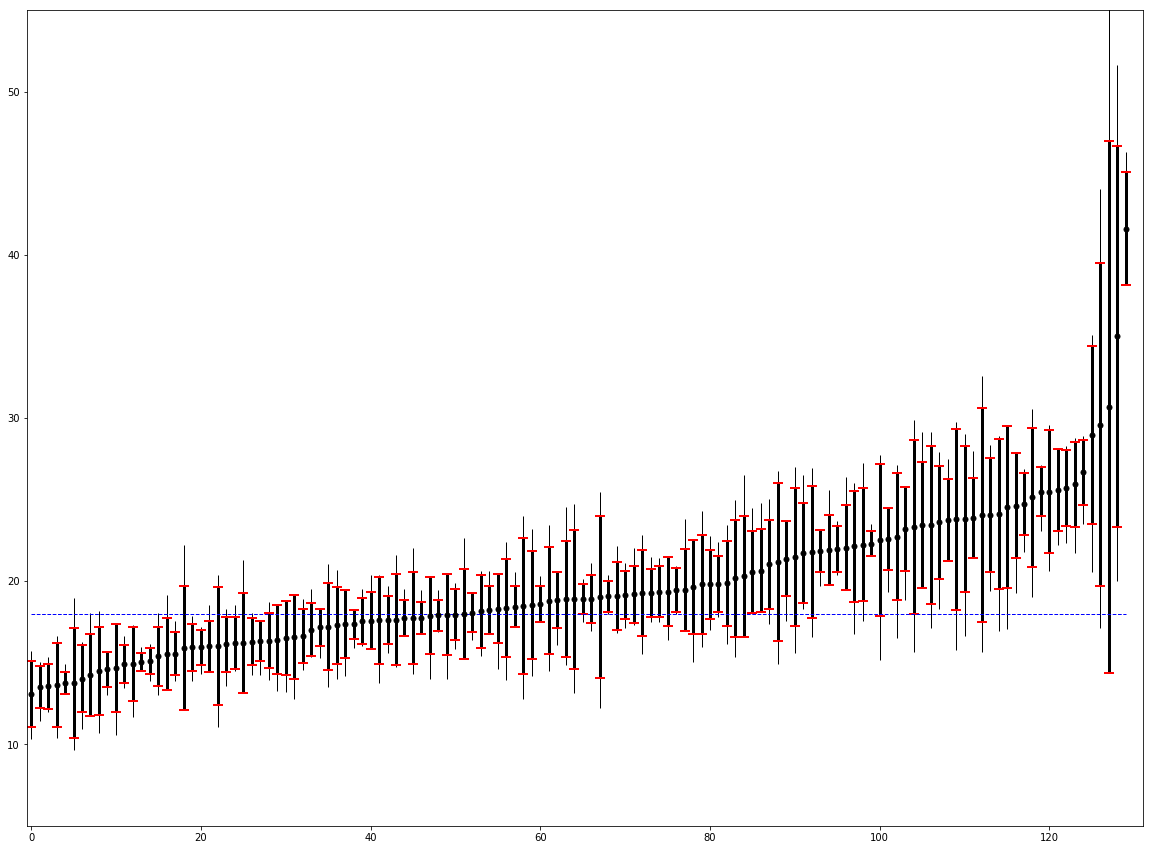

In [0]:
X0 = np.arange(len(perm_list))
X1 = testScore
Z0 = np.ones((len(perm_list),1)) * 18.0
mins = X1.min(0)
maxs = X1.max(0)
means = X1.mean(0)
std = X1.std(0)


ind_mean = np.argsort(means)
ls_mean = [x for x in ind_mean]
model_mean = [(perm_list[x], means[x],X1[:,x],testPearsonr[:,x]) for x in ls_mean]


ind_week1 = np.argsort(X1[0,:])
ls_week1 = [x for x in ind_week1]
model_week1 = [(perm_list[x], X1[:,x],testPearsonr[:,x]) for x in ls_week1]

ind_week2 = np.argsort(X1[1,:])
ls_week2 = [x for x in ind_week2]
model_week2 = [(perm_list[x], X1[:,x],testPearsonr[:,x]) for x in ls_week2]

ind_week3 = np.argsort(X1[2,:])
ls_week3 = [x for x in ind_week3]
model_week3 = [(perm_list[x], X1[:,x],testPearsonr[:,x]) for x in ls_week3]

ind_week4 = np.argsort(X1[3,:])
ls_week4 = [x for x in ind_week4]
model_week4 = [(perm_list[x], X1[:,x],testPearsonr[:,x]) for x in ls_week4]




plt.figure(figsize=(20,15))
(_, caps, _) = plt.errorbar(X0, means[ind_mean], std[ind_mean], fmt='ok', markersize=5, capsize=5, lw=3)
for cap in caps:
    cap.set_color('red')
    cap.set_markeredgewidth(2)
plt.plot(X0, Z0, '--', color='blue', lw=1)
plt.xlim((-.5,131))
plt.errorbar(X0, means[ind_mean], [means[ind_mean] - mins[ind_mean], maxs[ind_mean] - means[ind_mean]], fmt='.k', color='gray', lw=1)
plt.ylim(5,55)
plt.show()

Test Score: RMSE=9.68 r=0.93 p=0.00
Test Score: RMSE=12.50 r=0.90 p=0.00
Test Score: RMSE=13.86 r=0.87 p=0.00
Test Score: RMSE=18.98 r=0.73 p=0.00


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

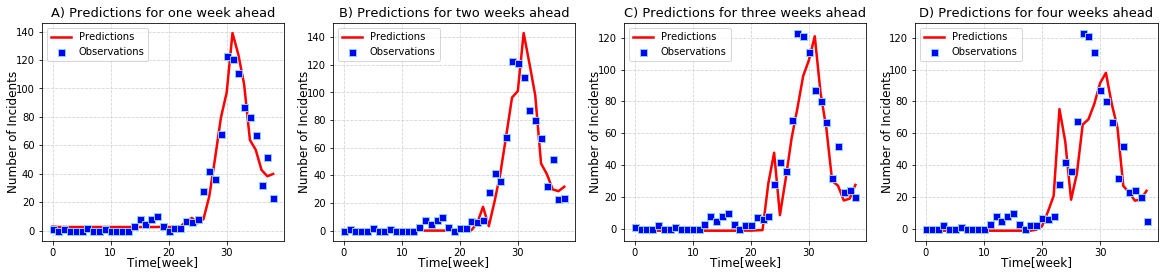

In [0]:
weekNum = ['one', 'two', 'three', 'four']
weekLabel = ['A)', 'B)', 'C)', 'D)']
csfont = {'fontname': 'Times New Roman'}
#fig = plt.subplots(2,2, figsize=(10,10))
fig = plt.figure(figsize=(20,4))
for seq1 in range(4):
    X = final_result[seq1,ind_week1[0],38:]
    Y1 = dataset[(len(train)+look_back+seq1):(len(dataset)-n_seq+seq1-1),0]
    Y = Y1[38:]
    RMSE = math.sqrt(mean_squared_error(X, Y))
    Z = np.reshape(Y,(1,len(Y)))[0]
    r,p = pearsonr(X,Z)
    abs1 = np.abs(Y-X)
    
    sse = np.sum((Y-X)**2)
    k = 10244
    n = len(X)
    AIC =  - 2*math.log(sse) #+ 2*k
    BIC = n*math.log(sse/n) #+ k*math.log(n)
    print('Test Score: RMSE=%.2f r=%.2f p=%.2f' % (RMSE, r**2, p))
    weekStr = ' weeks'
    if seq1 ==0 :
        weekStr = ' week'
    ax= fig.add_subplot(1, 4, seq1 + 1)
    titleName = ''.join([weekLabel[seq1],' Predictions for ', weekNum[seq1], weekStr, ' ahead'])
    if seq1 == 0:
        xlabel = 'Predictions'
    ylabel = 'Observations'
    
    plt.grid(True)
    plt.rc('grid', linestyle="--", color='lightgray')
    plt.subplot(1, 4, seq1+1)
    plt.plot(X,'-', markersize=8, color='red', linewidth=2.5, label= xlabel)
    plt.plot(Y, marker='s', markerfacecolor='blue', markersize=7, color='skyblue', linewidth=0, label=ylabel)
    plt.xlabel('Time[week]', fontsize=12, **csfont)
    plt.ylabel('Number of Incidents', fontsize=12, **csfont)
    plt.legend(loc='upper left')
    plt.title(titleName, fontsize=13, **csfont)
    
    ax = plt.gca()
    ax.xaxis.set_label_coords(.5, -0.07)
    ax.yaxis.set_label_coords(-0.088, .5)



plt.show()
fig.savefig('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/fig/model1_week1.pdf', format='pdf', dpi=500)

Test Score: RMSE=13.13 r=0.87 p=0.00
Test Score: RMSE=17.17 r=0.80 p=0.00
Test Score: RMSE=20.56 r=0.73 p=0.00
Test Score: RMSE=24.70 r=0.60 p=0.00


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

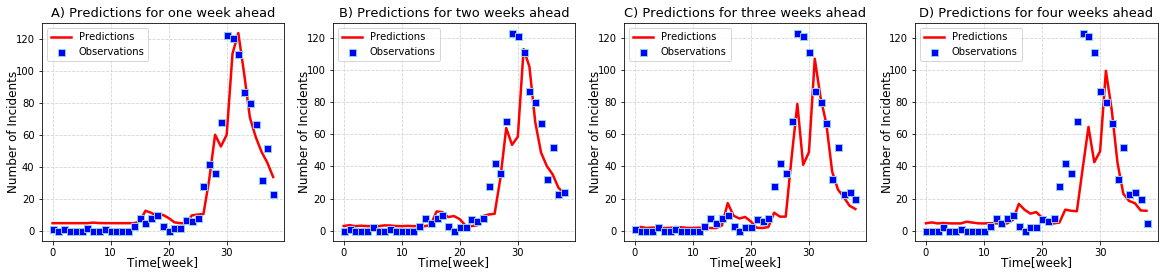

In [0]:
weekNum = ['one', 'two', 'three', 'four']
weekLabel = ['A)', 'B)', 'C)', 'D)']
csfont = {'fontname': 'Times New Roman'}
#fig = plt.subplots(2,2, figsize=(10,10))
fig = plt.figure(figsize=(20,4))
for seq1 in range(4):
    X = final_result[seq1, 0,38:]
    Y1 = dataset[(len(train)+look_back+seq1):(len(dataset)-n_seq+seq1-1),0]
    Y = Y1[38:]
    RMSE = math.sqrt(mean_squared_error(X, Y))
    Z = np.reshape(Y,(1,len(Y)))[0]
    r,p = pearsonr(X,Z)
    abs1 = np.abs(Y-X)
    
    sse = np.sum((Y-X)**2)
    k = 10244
    n = len(X)
    AIC =  - 2*math.log(sse) #+ 2*k
    BIC = n*math.log(sse/n) #+ k*math.log(n)
    print('Test Score: RMSE=%.2f r=%.2f p=%.2f' % (RMSE, r**2, p))
    weekStr = ' weeks'
    if seq1 ==0 :
        weekStr = ' week'
    ax= fig.add_subplot(1, 4, seq1 + 1)
    titleName = ''.join([weekLabel[seq1],' Predictions for ', weekNum[seq1], weekStr, ' ahead'])
    if seq1 == 0:
        xlabel = 'Predictions'
    ylabel = 'Observations'
    
    plt.grid(True)
    plt.rc('grid', linestyle="--", color='lightgray')
    plt.subplot(1, 4, seq1+1)
    plt.plot(X,'-', markersize=8, color='red', linewidth=2.5, label= xlabel)
    plt.plot(Y, marker='s', markerfacecolor='blue', markersize=7, color='skyblue', linewidth=0, label=ylabel)
    plt.xlabel('Time[week]', fontsize=12, **csfont)
    plt.ylabel('Number of Incidents', fontsize=12, **csfont)
    plt.legend(loc='upper left')
    plt.title(titleName, fontsize=13, **csfont)
    
    ax = plt.gca()
    ax.xaxis.set_label_coords(.5, -0.07)
    ax.yaxis.set_label_coords(-0.088, .5)



plt.show()
fig.savefig('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/fig/inf_week.pdf', format='pdf', dpi=500)

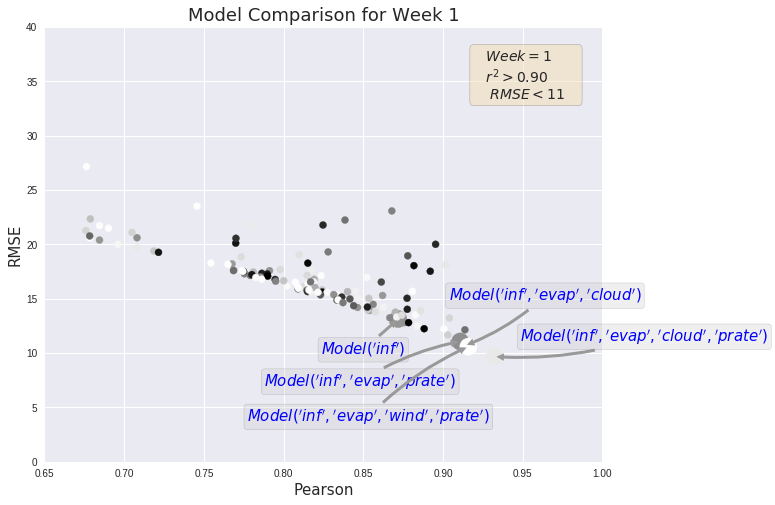

In [0]:
csfont = {'fontname': 'Times New Roman'}

nWeek = 0
N = testScore.shape[1]
np.random.seed(19680801)
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(N)
colors = (30 * np.random.rand(N)) ** 2

area = np.ones(N) * 50
for i in range(N):
    if ((testScore[nWeek, i] < 11.5) & (testPearsonr[nWeek, i] > 0.90)):
        area[i] = 300
        
area[0] = 300

plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))
data = [testPearsonr[nWeek,:], testScore[nWeek,:]]
#for i in range(N):
#    ax.scatter(testPearsonr[nWeek,i], testScore[nWeek,i], s=area[i], c=cmap(i))
ax.scatter(testPearsonr[nWeek,:], testScore[nWeek,:], s=area, c=colors)
plt.xlabel("Pearson", fontsize=15, **csfont)
plt.ylabel("RMSE", fontsize=15, **csfont)
plt.xlim([.65, 1])
plt.ylim([0,40])

bList = np.where((testScore[nWeek, :] < 11.5) & (testPearsonr[nWeek, :] > 0.90))[0]
aList = bList.tolist()

ls = [x for x in aList]
[perm_list[x] for x in ls]

Ntxt = len(aList)
txt = []
for i in range(Ntxt):
    txt.append('A' + str(i+1))

from matplotlib.patches import Ellipse
e1 = Ellipse((2, -1), 0.5, 0.5)
xyCoord = [[80, 40], [-100, -50], [150, 10],[-100, -80]]
ax.annotate(r'$'+'Model' + str(perm_list[0]).replace("[","(").replace("]",")")+'$', xy=(testPearsonr[nWeek,0], testScore[nWeek,0]),
            xytext=(-35,-40), 
            textcoords='offset points', ha='center', va='bottom', color='b',
            bbox=dict(boxstyle='round, pad=0.2', fc='.8', alpha=0.3),
            arrowprops=dict(arrowstyle='simple',
                                fc='0.6', ec='none', 
                                patchB=e1,
                                connectionstyle='arc3, rad=-0.0'),
                fontsize=15, **csfont)

for i, txt in enumerate(txt):
    ax.annotate(r'$'+'Model'+str(perm_list[aList[i]]).replace("[","(").replace("]",")")
                +'$', (testPearsonr[nWeek,bList[i]], testScore[nWeek,bList[i]]), 
                xytext=tuple(xyCoord[i]), 
                textcoords='offset points', ha='center', va='bottom', color='b',
                bbox=dict(boxstyle='round, pad=0.2', fc='.8', alpha=0.3),
                arrowprops=dict(arrowstyle='simple',
                                fc='0.6', ec='none', 
                                patchB=e1,
                                connectionstyle='arc3, rad=-0.1'),
                fontsize=15, **csfont)
    
textstr = '\n'.join(
    (r'   $Week=1$   ',
     r'   $r^2 > 0.90$   ',
     r'    $RMSE < 11$    ')
)
props = dict(boxstyle='round', fc='wheat', alpha=0.5)
ax.text(0.77, 0.95, textstr, transform=ax.transAxes, fontsize=14,
       verticalalignment='top', bbox=props)
plt.title("Model Comparison for Week 1", fontsize=18, **csfont)
fig.savefig('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/fig/plot_week1.pdf', format='pdf', dpi=500, bbox_inches="tight")

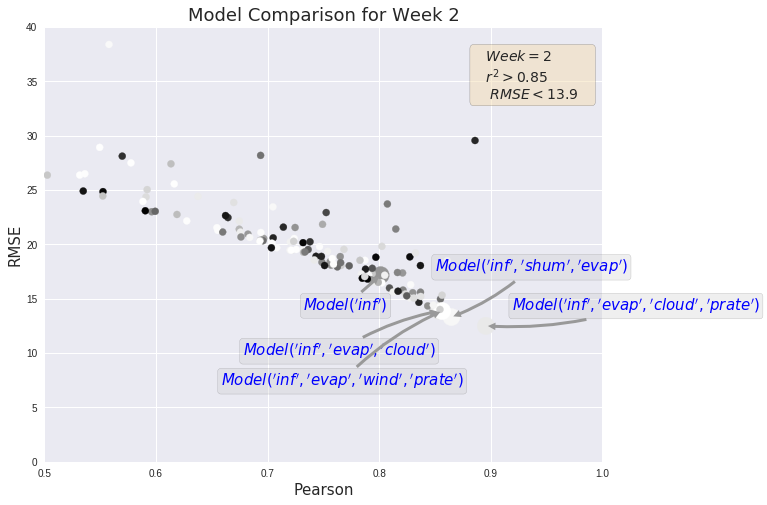

In [0]:
csfont = {'fontname': 'Times New Roman'}

nWeek = 1
N = testScore.shape[1]
np.random.seed(19680801)
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(N)
colors = (30 * np.random.rand(N)) ** 2

area = np.ones(N) * 50
for i in range(N):
    if ((testScore[nWeek, i] < 13.9) & (testPearsonr[nWeek, i] > 0.85)):
        area[i] = 300
        
area[0] = 300

plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))
data = [testPearsonr[nWeek,:], testScore[nWeek,:]]
#for i in range(N):
#    ax.scatter(testPearsonr[nWeek,i], testScore[nWeek,i], s=area[i], c=cmap(i))
ax.scatter(testPearsonr[nWeek,:], testScore[nWeek,:], s=area, c=colors)
plt.xlabel("Pearson", fontsize=15, **csfont)
plt.ylabel("RMSE", fontsize=15, **csfont)
plt.xlim([.5, 1])
plt.ylim([0,40])

bList = np.where((testScore[nWeek, :] < 13.9) & (testPearsonr[nWeek, :] > 0.85))[0]
aList = bList.tolist()

ls = [x for x in aList]
[perm_list[x] for x in ls]

Ntxt = len(aList)
txt = []
for i in range(Ntxt):
    txt.append('A' + str(i+1))

from matplotlib.patches import Ellipse
e1 = Ellipse((2, -1), 0.5, 0.5)
xyCoord = [[80, 40], [-100, -50], [150, 10],[-100, -80]]
ax.annotate(r'$'+'Model' + str(perm_list[0]).replace("[","(").replace("]",")")+'$', xy=(testPearsonr[nWeek,0], testScore[nWeek,0]),
            xytext=(-35,-40), 
            textcoords='offset points', ha='center', va='bottom', color='b',
            bbox=dict(boxstyle='round, pad=0.2', fc='.8', alpha=0.3),
            arrowprops=dict(arrowstyle='simple',
                                fc='0.6', ec='none', 
                                patchB=e1,
                                connectionstyle='arc3, rad=-0.0'),
                fontsize=15, **csfont)

for i, txt in enumerate(txt):
    ax.annotate(r'$'+'Model'+str(perm_list[aList[i]]).replace("[","(").replace("]",")")
                +'$', (testPearsonr[nWeek,bList[i]], testScore[nWeek,bList[i]]), 
                xytext=tuple(xyCoord[i]), 
                textcoords='offset points', ha='center', va='bottom', color='b',
                bbox=dict(boxstyle='round, pad=0.2', fc='.8', alpha=0.3),
                arrowprops=dict(arrowstyle='simple',
                                fc='0.6', ec='none', 
                                patchB=e1,
                                connectionstyle='arc3, rad=-0.1'),
                fontsize=15, **csfont)
    
textstr = '\n'.join(
    (r'   $Week=2$   ',
     r'   $r^2 > 0.85$   ',
     r'    $RMSE < 13.9$    ')
)
props = dict(boxstyle='round', fc='wheat', alpha=0.5)
ax.text(0.77, 0.95, textstr, transform=ax.transAxes, fontsize=14,
       verticalalignment='top', bbox=props)
plt.title("Model Comparison for Week 2", fontsize=18, **csfont)
fig.savefig('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/fig/plot_week2.pdf', format='pdf', dpi=500, bbox_inches="tight")

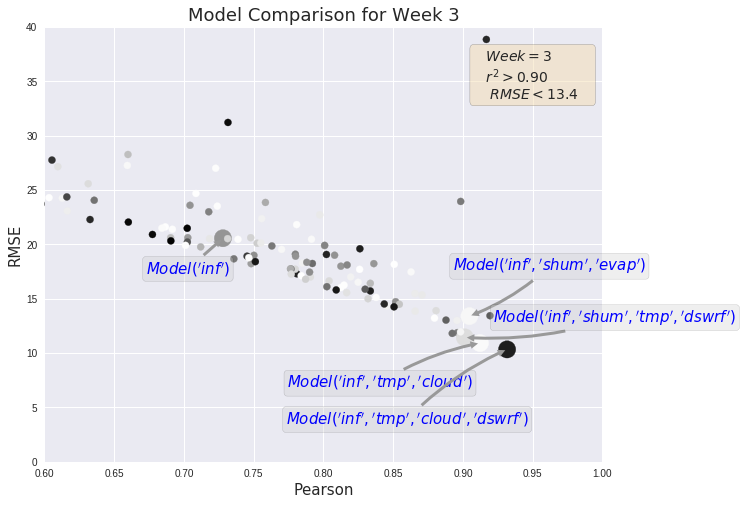

In [0]:
csfont = {'fontname': 'Times New Roman'}

nWeek = 2
N = testScore.shape[1]
np.random.seed(19680801)
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(N)
colors = (30 * np.random.rand(N)) ** 2

area = np.ones(N) * 50
for i in range(N):
    if ((testScore[nWeek, i] < 13.4) & (testPearsonr[nWeek, i] > 0.90)):
        area[i] = 300
        
area[0] = 300

plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))
data = [testPearsonr[nWeek,:], testScore[nWeek,:]]
#for i in range(N):
#    ax.scatter(testPearsonr[nWeek,i], testScore[nWeek,i], s=area[i], c=cmap(i))
ax.scatter(testPearsonr[nWeek,:], testScore[nWeek,:], s=area, c=colors)
plt.xlabel("Pearson", fontsize=15, **csfont)
plt.ylabel("RMSE", fontsize=15, **csfont)
plt.xlim([.6, 1])
plt.ylim([0,40])

bList = np.where((testScore[nWeek, :] < 13.4) & (testPearsonr[nWeek, :] > 0.90))[0]
aList = bList.tolist()

ls = [x for x in aList]
[perm_list[x] for x in ls]

Ntxt = len(aList)
txt = []
for i in range(Ntxt):
    txt.append('A' + str(i+1))

from matplotlib.patches import Ellipse
e1 = Ellipse((2, -1), 0.5, 0.5)
xyCoord = [[80, 40], [-100, -50], [150, 10],[-100, -80]]
ax.annotate(r'$'+'Model' + str(perm_list[0]).replace("[","(").replace("]",")")+'$', xy=(testPearsonr[nWeek,0], testScore[nWeek,0]),
            xytext=(-35,-40), 
            textcoords='offset points', ha='center', va='bottom', color='b',
            bbox=dict(boxstyle='round, pad=0.2', fc='.8', alpha=0.3),
            arrowprops=dict(arrowstyle='simple',
                                fc='0.6', ec='none', 
                                patchB=e1,
                                connectionstyle='arc3, rad=-0.0'),
                fontsize=15, **csfont)

for i, txt in enumerate(txt):
    ax.annotate(r'$'+'Model'+str(perm_list[aList[i]]).replace("[","(").replace("]",")")
                +'$', (testPearsonr[nWeek,bList[i]], testScore[nWeek,bList[i]]), 
                xytext=tuple(xyCoord[i]), 
                textcoords='offset points', ha='center', va='bottom', color='b',
                bbox=dict(boxstyle='round, pad=0.2', fc='.8', alpha=0.3),
                arrowprops=dict(arrowstyle='simple',
                                fc='0.6', ec='none', 
                                patchB=e1,
                                connectionstyle='arc3, rad=-0.1'),
                fontsize=15, **csfont)
    
textstr = '\n'.join(
    (r'   $Week=3$   ',
     r'   $r^2 > 0.90$   ',
     r'    $RMSE < 13.4$    ')
)
props = dict(boxstyle='round', fc='wheat', alpha=0.5)
ax.text(0.77, 0.95, textstr, transform=ax.transAxes, fontsize=14,
       verticalalignment='top', bbox=props)
plt.title("Model Comparison for Week 3", fontsize=18, **csfont)
fig.savefig('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/fig/plot_week3.pdf', format='pdf', dpi=500, bbox_inches="tight")

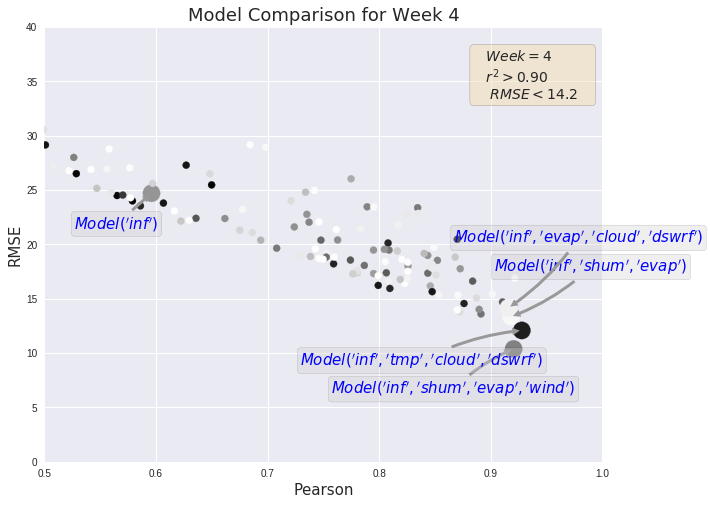

In [0]:
csfont = {'fontname': 'Times New Roman'}

nWeek = 3
N = testScore.shape[1]
np.random.seed(19680801)
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(N)
colors = (30 * np.random.rand(N)) ** 2

area = np.ones(N) * 50
for i in range(N):
    if ((testScore[nWeek, i] < 14.2) & (testPearsonr[nWeek, i] > 0.90)):
        area[i] = 300
        
area[0] = 300

plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))
data = [testPearsonr[nWeek,:], testScore[nWeek,:]]
#for i in range(N):
#    ax.scatter(testPearsonr[nWeek,i], testScore[nWeek,i], s=area[i], c=cmap(i))
ax.scatter(testPearsonr[nWeek,:], testScore[nWeek,:], s=area, c=colors)
plt.xlabel("Pearson", fontsize=15, **csfont)
plt.ylabel("RMSE", fontsize=15, **csfont)
plt.xlim([.5, 1])
plt.ylim([0,40])

bList = np.where((testScore[nWeek, :] < 14.2) & (testPearsonr[nWeek, :] > 0.90))[0]
aList = bList.tolist()

ls = [x for x in aList]
[perm_list[x] for x in ls]

Ntxt = len(aList)
txt = []
for i in range(Ntxt):
    txt.append('A' + str(i+1))

from matplotlib.patches import Ellipse
e1 = Ellipse((2, -1), 0.5, 0.5)

xyCoord = [[80, 40], [-60, -50], [70, 60],[-100, -40]]
ax.annotate(r'$'+'Model' + str(perm_list[0]).replace("[","(").replace("]",")")+'$', xy=(testPearsonr[nWeek,0], testScore[nWeek,0]),
            xytext=(-35,-40), 
            textcoords='offset points', ha='center', va='bottom', color='b',
            bbox=dict(boxstyle='round, pad=0.2', fc='.8', alpha=0.3),
            arrowprops=dict(arrowstyle='simple',
                                fc='0.6', ec='none', 
                                patchB=e1,
                                connectionstyle='arc3, rad=-0.0'),
                fontsize=15, **csfont)

for i, txt in enumerate(txt):
    ax.annotate(r'$'+'Model'+str(perm_list[aList[i]]).replace("[","(").replace("]",")")
                +'$', (testPearsonr[nWeek,bList[i]], testScore[nWeek,bList[i]]), 
                xytext=tuple(xyCoord[i]), 
                textcoords='offset points', ha='center', va='bottom', color='b',
                bbox=dict(boxstyle='round, pad=0.2', fc='.8', alpha=0.3),
                arrowprops=dict(arrowstyle='simple',
                                fc='0.6', ec='none', 
                                patchB=e1,
                                connectionstyle='arc3, rad=-0.1'),
                fontsize=15, **csfont)
    
textstr = '\n'.join(
    (r'   $Week=4$   ',
     r'   $r^2 > 0.90$   ',
     r'    $RMSE < 14.2$    ')
)
props = dict(boxstyle='round', fc='wheat', alpha=0.5)
ax.text(0.77, 0.95, textstr, transform=ax.transAxes, fontsize=14,
       verticalalignment='top', bbox=props)
plt.title("Model Comparison for Week 4", fontsize=18, **csfont)
fig.savefig('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/fig/plot_week4.pdf', format='pdf', dpi=500, bbox_inches="tight")

In [0]:
testScore

array([[19.03451708, 20.02297835, 17.41583979, 19.05287352, 26.2911854 ,
        19.23911739, 18.21186501, 18.71588998, 17.95626617, 18.45645007,
        14.39389632, 15.30898553, 15.166082  , 17.91661587, 20.80258599,
        19.72788094, 20.93434286, 20.42417566, 19.43129421, 25.29487658,
        19.25250521, 14.93220065, 18.6463115 , 19.11927477, 17.24043189,
        23.73865242, 21.92195419, 16.916977  , 19.07712002, 18.60189993,
        19.70036095, 23.44727265, 26.49993345, 30.84159336, 28.74811881,
        30.46759324, 18.54509588, 21.48670331, 19.37228649, 20.38556133,
        20.782312  , 17.90323736, 21.65512567, 19.30434442, 19.45152615,
        17.91502661, 18.07843796, 22.44589302, 20.57563969, 15.96980546,
        13.97958144, 21.10615031, 17.52414728, 19.78104075, 18.40838044,
        17.6033614 , 16.95041624, 16.33669952, 20.09364025, 20.48561334,
        17.60252485, 18.81948911, 20.28667556, 18.92584391, 19.22724032,
        17.80464994, 18.31375587, 19.7415273 , 18.1

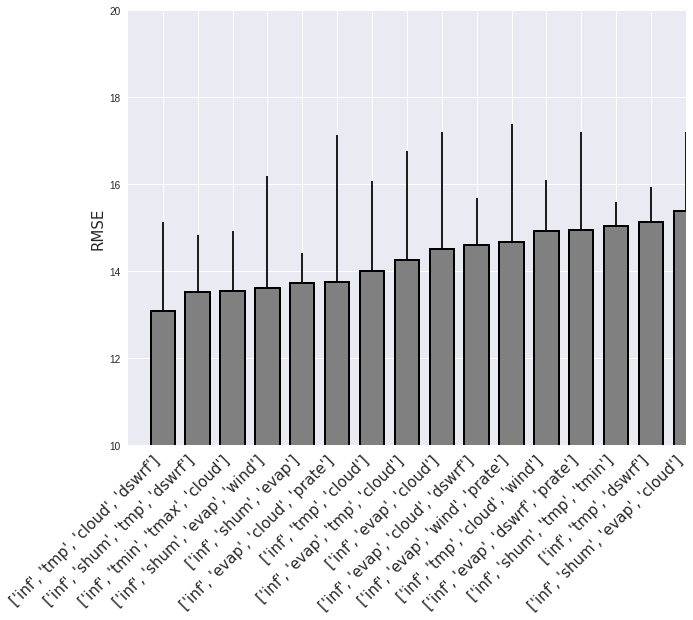

In [0]:
X0 = np.arange(len(perm_list))
X1 = testScore
Z0 = np.ones((len(perm_list),1)) * 15.0
mins = X1.min(0)
maxs = X1.max(0)
means = X1.mean(0)
std = X1.std(0)
ind = X0#np.argsort(means)

ind = np.argsort(means)
means[ind_mean]

b = np.where(means[ind_mean] < 15.5)[0]
a = b.tolist()

ls = [x for x in a]
[(perm_list[ind_mean[x]], means[ind_mean][x]) for x in ls]

xlabel_list = [perm_list[ind_mean[x]] for x in ls]
xLabels = ['%s' % i for i in xlabel_list ]

yerr_upper = std[ind_mean]
yerr_lower = np.zeros(len(yerr_upper))
csfont = {'fontname': 'Times New Roman'}
fig = plt.figure(figsize=(10,8))
plt.bar(X0, means[ind], width=0.7, color='0.5', edgecolor='k', yerr=[yerr_lower, yerr_upper], linewidth=2, capsize=10)

plt.xlim((-1,10+.5))
plt.ylim(10,20)
plt.xticks(range(len(b)), xLabels, rotation=45, ha='right', fontsize=15, **csfont)
plt.ylabel('RMSE', fontsize=15, **csfont)
ax = plt.gca()
#ax.yaxis.set_label_coords(-.065, .5)
plt.show()
fig.savefig('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/fig/hist_mean.pdf', format='pdf', dpi=100, bbox_inches="tight")

In [0]:
param_list = ['shum', 'evap', 'tmp', 'tmin', 'tmax', 'cloud', 'wind', 'dswrf', 'prate']
hist_mean = np.zeros((130, 9))
hist_week1 = np.zeros((130, 9))
hist_week2 = np.zeros((130, 9))
hist_week3 = np.zeros((130, 9))
hist_week4 = np.zeros((130, 9))

for T in range(130):
    for i in range(T):
        for j in range(9):
            if param_list[j] in model_mean[i][0]:
                hist_mean[T,j] = hist_mean[T,j] + 1
                
            if param_list[j] in model_week1[i][0]:
                hist_week1[T,j] = hist_week1[T,j] + 1
                
            if param_list[j] in model_week2[i][0]:
                hist_week2[T,j] = hist_week2[T,j] + 1
                
            if param_list[j] in model_week3[i][0]:
                hist_week3[T,j] = hist_week3[T,j] + 1
            
            if param_list[j] in model_week4[i][0]:
                hist_week4[T,j] = hist_week4[T,j] + 1

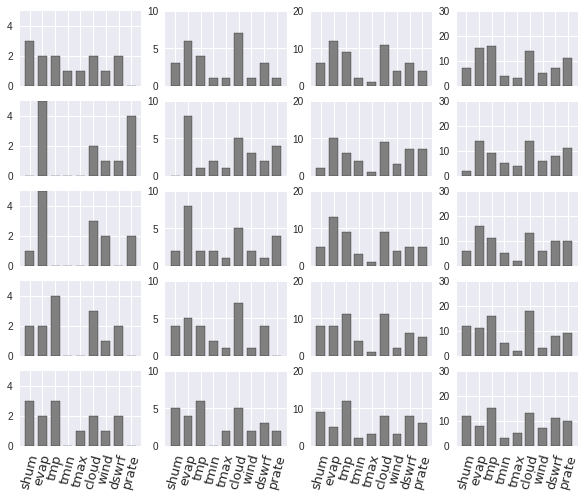

In [0]:
csfont = {'fontname': 'Times New Roman'}

Model_Num = [5, 10, 20, 30, 5, 10, 20, 30, 5, 10, 20, 30, 5, 10, 20, 30, 5, 10, 20, 30]

plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))

for i in range(4):
    plt.subplot(5, 4, i+1)
    plt.bar(range(9), hist_mean[Model_Num[i],:], width=0.7, color='0.5', edgecolor='k')
    #ax.xaxis.label.set_visible(False)
    plt.xticks(range(9), [], rotation=45, ha='right', fontsize=15, **csfont)
    plt.ylim([0,Model_Num[i]])

    plt.subplot(5, 4, i+5)
    plt.bar(range(9), hist_week1[Model_Num[i],:], width=0.7, color='0.5', edgecolor='k')
    plt.xticks(range(9), [], rotation=45, ha='right', fontsize=15, **csfont)
    plt.ylim([0,Model_Num[i]])

    plt.subplot(5, 4, i+9)
    plt.bar(range(9), hist_week2[Model_Num[i],:], width=0.7, color='0.5', edgecolor='k')
    plt.xticks(range(9), [], rotation=45, ha='right', fontsize=15, **csfont)
    plt.ylim([0,Model_Num[i]])

    plt.subplot(5, 4, i+13)
    plt.bar(range(9), hist_week3[Model_Num[i],:], width=0.7, color='0.5', edgecolor='k')
    plt.xticks(range(9), [], rotation=45, ha='right', fontsize=15, **csfont)
    plt.ylim([0,Model_Num[i]])

    plt.subplot(5, 4, i+17)
    plt.bar(range(9), hist_week4[Model_Num[i],:], width=0.7, color='0.5', edgecolor='k')
    plt.xticks(range(9), param_list, rotation=75, ha='center', fontsize=13, **csfont)
    plt.ylim([0,Model_Num[i]])

fig.savefig('./gdrive/My Drive/Colab Notebooks/Tensorflow/Iran/fig/hist_variables.pdf', format='pdf', dpi=100, bbox_inches="tight")

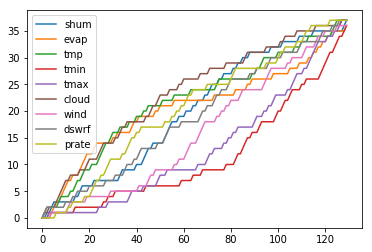

In [0]:
plt.plot(hist_mean[:,0:10])
plt.legend(param_list[0:10])

In [0]:
model_mean

[(['inf', 'tmp', 'cloud', 'dswrf'],
  13.086909075648384,
  array([14.23560884, 15.69069159, 10.33974917, 12.08158671]),
  array([0.85257351, 0.81679132, 0.93164049, 0.92775055])),
 (['inf', 'shum', 'tmp', 'dswrf'],
  13.518754371065054,
  array([13.8109726 , 15.05792925, 11.4415964 , 13.76451923]),
  array([0.85746175, 0.83094645, 0.90133174, 0.87222026])),
 (['inf', 'tmin', 'tmax', 'cloud'],
  13.551127173869494,
  array([12.49912838, 14.41396581, 11.9544502 , 15.33696431]),
  array([0.88363995, 0.8484293 , 0.89829983, 0.85362786])),
 (['inf', 'shum', 'evap', 'wind'],
  13.61998156731898,
  array([16.61284782, 15.6028569 , 11.88581669, 10.37840485]),
  array([0.79501294, 0.83695725, 0.89608791, 0.92041124])),
 (['inf', 'shum', 'evap'],
  13.737953478779923,
  array([14.8983804 , 13.3133905 , 13.39896437, 13.34107865]),
  array([0.83364126, 0.86466139, 0.9046238 , 0.91806327])),
 (['inf', 'evap', 'cloud', 'prate'],
  13.754234591357271,
  array([ 9.67758936, 12.50244014, 13.85526117, 

In [0]:
a = [2, 10, 2, 45, 6]
b = [1, 3, 4, 78, 1]
pearsonr(a,b)

(0.9829265168229097, 0.0026711709547670194)

In [0]:
from scipy import stats
s, i, r, p, std = stats.linregress(a,b)

In [0]:
r**2

0.9661445374736177

In [0]:
p

0.002671170954767019

In [0]:
r2_score(X,Y)

-0.31536637889294483

In [0]:
bList = np.where((testScore[3, :] < 14) & (testPearsonr[3, :] > 0.80))[0]
bList

array([ 10,  50, 100, 105], dtype=int64)

In [0]:
X = final_result[seq1,0,40:]

In [0]:
Y1 = dataset[(len(train)+4+0):(len(dataset)-4+0-1),0]

In [0]:
ind_week1[1]

93

In [0]:
bList = np.where((testScore[3, :] < 14.2) & (testPearsonr[3, :] > 0.90))[0]
bList

array([ 10,  50,  90, 105], dtype=int64)

In [0]:
testScore[nWeek, :]

array([20.5645918 , 19.09471348, 19.00202016, 19.86903748, 22.04740417,
       23.59356595, 19.53787374, 21.81729138, 18.22867908, 18.99242161,
       13.39896437, 18.2755954 , 31.21259751, 20.61688467, 17.00049479,
       17.99167041, 20.52502463, 17.29528089, 18.10473404, 26.29479214,
       23.85491311, 15.34330517, 20.10255807, 18.24094564, 18.34709479,
       24.2570092 , 27.00356515, 10.91839309, 20.46134739, 13.90255879,
       14.32925728, 23.07497812, 20.91013329, 26.1582691 , 25.81094232,
       24.05917254, 32.39866043, 25.57929727, 22.36390779, 28.34978994,
       18.16283633, 15.47699326, 24.80752721, 21.39138851, 19.90769503,
       19.76495805, 14.62073563, 38.84801371, 27.25834984, 13.03398565,
       11.88581669, 24.68271744, 14.48021541, 14.51784992, 17.46453314,
       15.71600099, 16.63801686, 11.4415964 , 16.02452158, 20.47126003,
       14.72713778, 17.71771864, 23.94851326, 18.91324519, 18.66882147,
       19.07030831, 16.41952309, 20.60755566, 18.2265631 , 16.51